## Apple Music Replay - Recreated using BigQuery

Apple music has recently launched a 'replay' feature much akin to 'Spotify wrapped', although they only provide a high level summary of a user's listening history. Throughout this notebook, I aim to drill down slightly deeper on what I've been listening too for the last 5 years.

In [52]:
import os
import numpy as np
from google.cloud import bigquery
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

#sns.set()
sns.set_style("white")

Export api_key as a environment variable and set up a bigquery client instance.

In [53]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/jcmunday/Desktop/apple_music_replay/apple-music-replay-3ccf5c1d512e.json"     
client = bigquery.Client()

### Overview of Listening Habits
Now let's begin with a high level analysis of my listening habits, through inspecting ```Apple Music Play Activity.csv```. You will need to upload this into a GCP bucket inside your project and then load this as a dataset into BigQuery. I give full details how to do this using the gcloud command line tools in the README.md for this project.

   year  hours_listened
0  2021           310.4
1  2020           918.6
2  2019           987.0
3  2018          1097.1
4  2017           920.2
5  2016           241.9


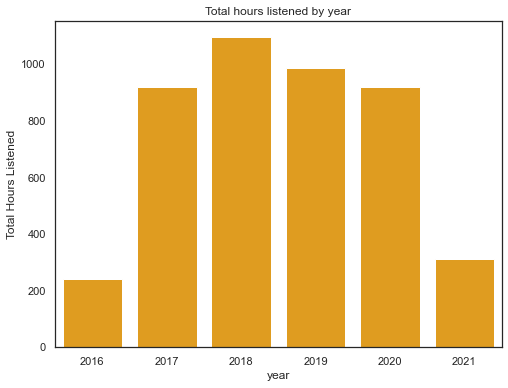

In [12]:
HoursListened = """
    SELECT EXTRACT(YEAR FROM Event_End_Timestamp) year, ROUND(SUM(Play_Duration_Milliseconds)/(60*60*1000),1) AS hours_listened
    FROM `apple-music-replay.apple_music_data.listening_history`
    GROUP BY year
    HAVING year IS NOT NULL
    ORDER BY year DESC
    """
df = client.query(HoursListened).to_dataframe()
print(df.head(10))

plt.figure(figsize=(6, 6))
sns.set_context('notebook')
plt.title('Total hours listened by year')
sns.barplot(data=df, x='year', y='hours_listened', ci=None, color='orange')
plt.ylabel('Total Hours Listened')
plt.show()

Mean # of hours listened in 1 day: 2.5.
Max # of hours listened in 1 day: 9.3.


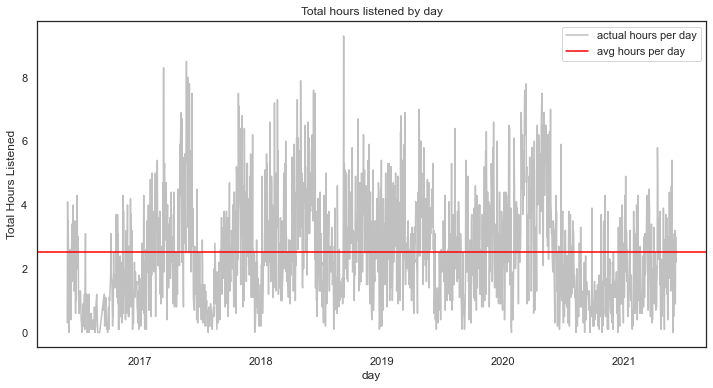

In [8]:
HoursListened_by_day = """
    SELECT EXTRACT(DATE FROM Event_End_Timestamp) day, ROUND(SUM(Play_Duration_Milliseconds)/(60*60*1000),1) AS hours_listened
    FROM `apple-music-replay.apple_music_data.listening_history`
    GROUP BY day
    """
df = client.query(HoursListened_by_day).to_dataframe()
avg_hours = df['hours_listened'].mean()
max_hours = df['hours_listened'].max()

print(f'Mean # of hours listened per day: {round(avg_hours,1)}.')
print(f'Max # of hours listened in 1 day: {max_hours}.')

#print(df.head(50))

plt.figure(figsize=(12, 6))
sns.set_context('notebook')

plt.title('Total hours listened by day')
sns.lineplot(data=df, x='day', y='hours_listened', ci=None, color='#C0C0C0', label='actual hours per day')
plt.axhline(avg_hours,color='r', linestyle='-', label='avg hours per day')
plt.ylabel('Total Hours Listened')
plt.legend(loc="upper right")
plt.show()

Looking at the listening history on a day level is too granular to draw any insightful conclusions. Lets instead aggregated by month of the year

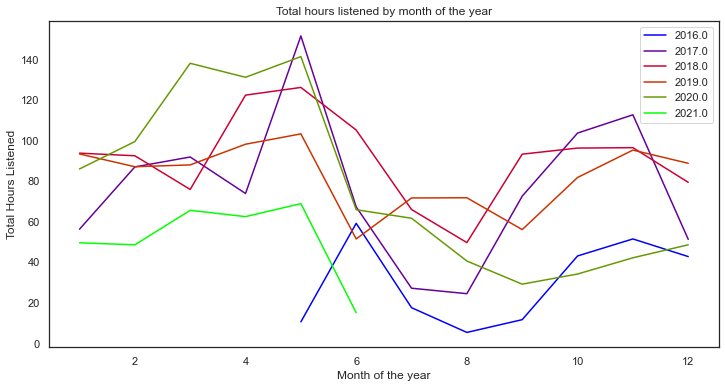

In [5]:
hours_listened_by_month = """
    SELECT EXTRACT(YEAR FROM Event_End_Timestamp) year, EXTRACT(MONTH FROM Event_End_Timestamp) month, ROUND(SUM(Play_Duration_Milliseconds)/(60*60*1000),1) AS hours_listened
    FROM `apple-music-replay.apple_music_data.listening_history`
    GROUP BY year, month
    ORDER BY month
    """
df = client.query(hours_listened_by_month).to_dataframe()
avg_hours = df['hours_listened'].mean()
#print(df.head(50))

plt.figure(figsize=(12, 6))
sns.set_context('notebook')
#sns.set_palette("bright")

plt.title('Total hours listened by month of the year')
sns.lineplot(data=df, x='month', y='hours_listened', ci=None, hue='year', palette = 'brg')
plt.xlabel('Month of the year')
plt.ylabel('Total Hours Listened')
plt.legend(loc="upper right")
plt.show()

Interestingly my listening peaks around may/june time, which coincedes with when I would typically have spent most days in the library studying for my uni exams.

### Artist Popularity

In [6]:
uniqueArtistByYear = """
    SELECT EXTRACT(YEAR FROM Event_End_Timestamp) year, COUNT(DISTINCT Artist_Name) uniqueArtists
    FROM `apple-music-replay.apple_music_data.listening_history`
    GROUP BY year
    HAVING year IS NOT NULL
    ORDER BY year ASC
    """
df = client.query(uniqueArtistByYear).to_dataframe()
print(df.head(10))

   year  uniqueArtists
0  2016            246
1  2017            612
2  2018            999
3  2019           1204
4  2020           1049
5  2021            512


In [7]:
Top10_AllYears = """
    SELECT Artist_Name, ROUND(SUM(Play_Duration_Milliseconds)/(60*60*1000.0),1) AS hours_listened
    FROM `apple-music-replay.apple_music_data.listening_history`
    GROUP BY Artist_Name
    ORDER BY hours_listened DESC
    LIMIT 10
    """
df  = client.query(Top10_AllYears).to_dataframe()
print(df.head(15))

      Artist_Name  hours_listened
0      John Mayer           164.7
1  Kendrick Lamar           159.4
2         J. Cole           122.0
3  Anderson .Paak           108.0
4           Logic           102.9
5           Foals            96.3
6      Kanye West            90.0
7     Lupe Fiasco            78.2
8       Tom Misch            61.1
9           JAY-Z            59.5


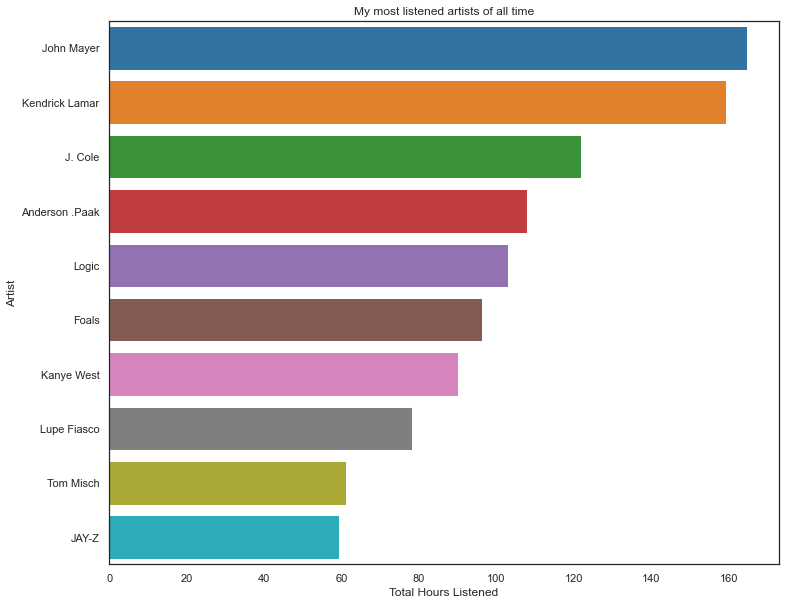

In [8]:
plt.figure(figsize=(12,8))
sns.set_context('notebook')


sns.set_color_codes("pastel")
sns.barplot(x="hours_listened", y="Artist_Name", data=df)
plt.title("My most listened artists of all time")
plt.xlabel("Total Hours Listened")
plt.ylabel("Artist")

plt.show()

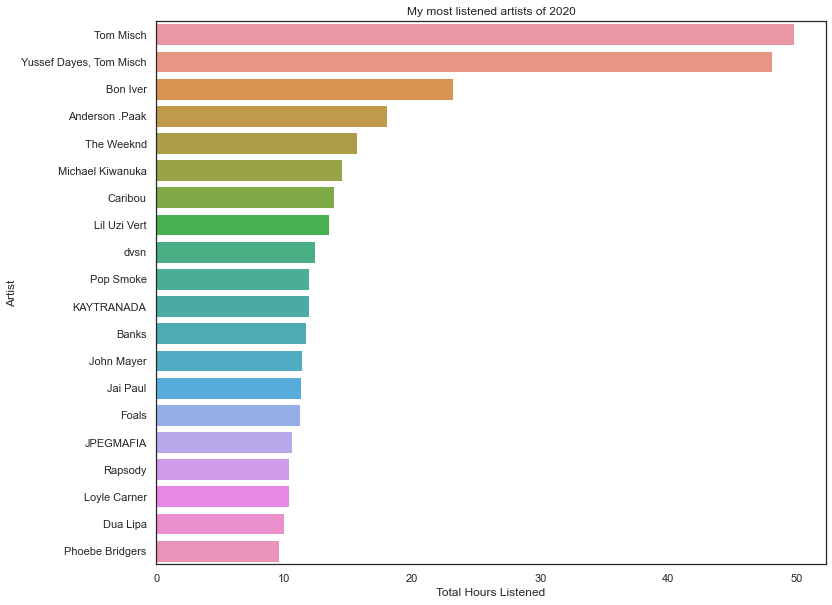

In [9]:
Top10_2020_Only = """
    SELECT Artist_Name, ROUND(SUM(Play_Duration_Milliseconds)/(60*60*1000.0),1) hours_listened, count(*) play_count, RANK() OVER(ORDER BY SUM(Play_Duration_Milliseconds)/(60*60*1000.0) DESC) AS rank
    FROM `apple-music-replay.apple_music_data.listening_history`
    WHERE EXTRACT(YEAR FROM Event_End_Timestamp) = 2020 
    GROUP BY Artist_Name
    ORDER BY hours_listened DESC
    LIMIT 20
    """
df  = client.query(Top10_2020_Only).to_dataframe()

plt.figure(figsize=(12,8))
sns.set_context('notebook')
sns.set_color_codes("pastel")
sns.barplot(x="hours_listened", y="Artist_Name", data=df)
plt.title("My most listened artists of 2020")
plt.xlabel("Total Hours Listened")
plt.ylabel("Artist")

plt.show()

In [10]:
rank_by_year= """
    SELECT RANK() OVER(PARTITION BY  year  ORDER BY  hours_listened DESC ) rank, year, Artist_name, hours_listened
    FROM
        (SELECT  Artist_Name, EXTRACT(YEAR FROM Event_End_Timestamp) year, SUM(Play_Duration_Milliseconds)/(60*60*1000.0) AS hours_listened
        FROM `apple-music-replay.apple_music_data.listening_history`
        GROUP BY Artist_Name, year
        HAVING year IS NOT NULL
        ORDER BY hours_listened DESC)
    ORDER BY rank ASC, year
    """
df=client.query(rank_by_year).to_dataframe()
print(df.head(15))

    rank  year              Artist_name  hours_listened
0      1  2016         Ludovico Einaudi       22.878768
1      1  2017               John Mayer       90.287533
2      1  2018               Kanye West       60.564022
3      1  2019           Anderson .Paak       47.536626
4      1  2020                Tom Misch       49.762552
5      1  2021                Radiohead       14.969546
6      2  2016     The Notorious B.I.G.       18.504922
7      2  2017           Kendrick Lamar       62.322433
8      2  2018           Kendrick Lamar       56.763233
9      2  2019                   Skepta       28.845409
10     2  2020  Yussef Dayes, Tom Misch       48.102186
11     2  2021             Jordan Rakei       13.781110
12     3  2016                  J. Cole       18.044638
13     3  2017                    Logic       58.622628
14     3  2018                  J. Cole       42.383546


In [11]:
pivot_table = df.pivot_table(index=['rank'],
                            columns=['year'],
                            values=['Artist_name'],
                            aggfunc=lambda x: ' '.join(str(ch) for ch in x))
pivot_table.to_csv('output_data/ArtistRankingByYear.csv', encoding='utf-8',index=False)
pivot_table.head(25)

Artist_name  \
year                                     2016   
rank                                            
1                            Ludovico Einaudi   
2                        The Notorious B.I.G.   
3                                     J. Cole   
4                              Kendrick Lamar   
5                               Bryson Tiller   
6                           Chance the Rapper   
7                                       Foals   
8                               Ariana Grande   
9                                    Ice Cube   
10                                   A$AP Mob   
11                           Childish Gambino   
12                                Joey Bada$$   
13                                   2 Chainz   
14                                      JAY-Z   
15                           Shelley FKA DRAM   
16                                 Kanye West   
17                        Nothing But Thieves   
18                             Arctic Monkeys   
19                                 Disclosure   
20                                  Mura Masa   
21    Ludovico Einaudi, Amsterdam Sinfonietta   
22                                Lupe Fiasco   
23                                    Jamie T   
24                               Wu-Tang Clan   
25                                Circa Waves   

                                                    \
year                                          2017   
rank                                                 
1                                       John Mayer   
2                                   Kendrick Lamar   
3                                            Logic   
4                                          J. Cole   
5                                              Nas   
6                                            Foals   
7                                      Joey Bada$$   
8                                            JAY-Z   
9                                 Ludovico Einaudi   
10                                       Wretch 32   
11                                     Lupe Fiasco   
12                                Childish Gambino   
13                                      A$AP Rocky   
14                               Chance the Rapper   
15                                            2Pac   
16    Herbert von Karajan, Berliner Philharmoniker   
17                            The Notorious B.I.G.   
18                                     Post Malone   
19                                   Bryson Tiller   
20                                        2 Chainz   
21                                    Travis Scott   
22                                           Peace   
23                                    Lil Uzi Vert   
24                             Bombay Bicycle Club   
25                                     Spring King   

                                                        \
year                         2018                 2019   
rank                                                     
1                      Kanye West       Anderson .Paak   
2                  Kendrick Lamar               Skepta   
3                         J. Cole                Foals   
4                  Anderson .Paak                Banks   
5                     Lupe Fiasco               Hozier   
6                      John Mayer        Billie Eilish   
7                           Logic  Nothing But Thieves   
8                     Jorja Smith                 Dave   
9                         Pusha T            JPEGMAFIA   
10                     A$AP Rocky              J. Cole   
11                      Wretch 32           Sam Fender   
12                   Travis Scott       Kendrick Lamar   
13                          Migos           John Mayer   
14                          6LACK          James Blake   
15                            SZA          Lupe Fiasco   
16                   Leon Bridges          Pink Sweat$   
17                            Nas             

In [25]:
journey_to_most_listened = """
SELECT Artist_Name, 
    EXTRACT(DATE FROM Event_End_Timestamp) date_of_play, 
    (1/(60*60*1000))*SUM(Play_Duration_Milliseconds) OVER (PARTITION BY Artist_Name ORDER BY Event_End_Timestamp) Running_Total_Play_Time
FROM `apple-music-replay.apple_music_data.listening_history`
WHERE Artist_Name IN ('John Mayer', 'Tom Misch', 'Bon Iver','Kendrick Lamar', 'J. Cole','Anderson .Paak','Logic', 'Foals', 'Kanye West', 'Lupe Fiasco', 'JAY-Z') AND
    EXTRACT(DATE FROM Event_End_Timestamp) IS NOT NULL
ORDER BY Event_End_Timestamp ASC
"""

df=client.query(journey_to_most_listened).to_dataframe()
print(df.tail(5))

          Artist_Name date_of_play  Running_Total_Play_Time
28503        Bon Iver   2021-06-07                27.388852
28504  Kendrick Lamar   2021-06-07               159.358337
28505           Logic   2021-06-07               102.880838
28506      John Mayer   2021-06-07               164.655763
28507      John Mayer   2021-06-07               164.664517


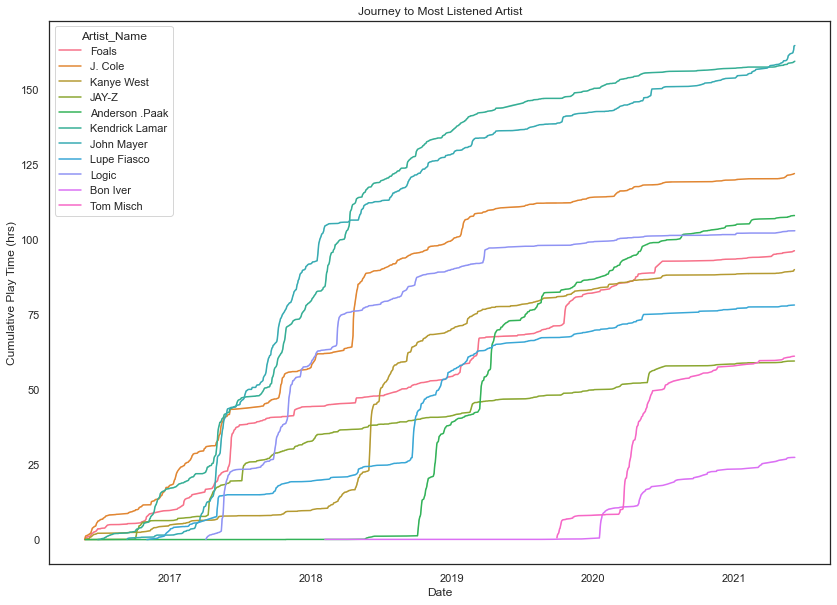

In [26]:
plt.figure(figsize=(12,8))

sns.set_context('notebook')
sns.set_color_codes("pastel")

sns.lineplot(x='date_of_play', y='Running_Total_Play_Time', hue='Artist_Name', data=df)

plt.title('Journey to Most Listened Artist')
plt.xlabel('Date')
plt.ylabel('Cumulative Play Time (hrs)')
plt.show()

Interestingly, we see that artists like John Mayer have been consistently in my rotation with his gradient of cumulative play time still increasing. However artists like Kendrick and Cole have sharply plateaued over the last two years as I have increased the breadth of genres and artists I listen to. Let's try to confirm this by repeating the prior for genre instead of artist.

In [37]:
journey_to_most_listened_genre = """
SELECT Genre,
    EXTRACT(DATE FROM Event_End_Timestamp) date_of_play, 
    (1/(60*60*1000))*SUM(Play_Duration_Milliseconds) OVER (PARTITION BY Genre ORDER BY Event_End_Timestamp) Running_Total_Play_Time
FROM `apple-music-replay.apple_music_data.listening_history`
WHERE EXTRACT(DATE FROM Event_End_Timestamp) IS NOT NULL AND
genre IN (
        SELECT Genre
        FROM `apple-music-replay.apple_music_data.listening_history`
        GROUP BY Genre
        ORDER BY 1/(60*60*1000)*SUM(Play_Duration_Milliseconds) DESC
        LIMIT 10
)
ORDER BY Event_End_Timestamp ASC
"""

df=client.query(journey_to_most_listened_genre).to_dataframe()
print(df.tail(5))

              Genre date_of_play  Running_Total_Play_Time
121533  Hip Hop/Rap   2021-06-07              2102.895439
121534  Hip Hop/Rap   2021-06-07              2102.953805
121535  Hip Hop/Rap   2021-06-07              2103.012181
121536          Pop   2021-06-07               254.056984
121537          Pop   2021-06-07               254.065737


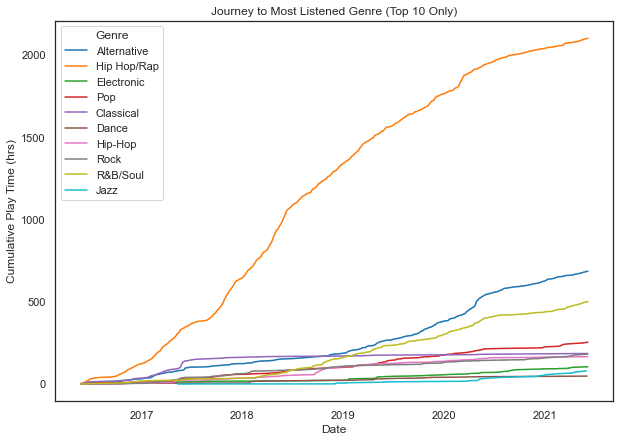

In [50]:
plt.figure(figsize=(12,8))

sns.set_context('notebook')
sns.set_color_codes("bright")
sns.lineplot(x='date_of_play', y='Running_Total_Play_Time', hue='Genre', data=df)
plt.title('Journey to Most Listened Genre (Top 10 Only)')
plt.xlabel('Date')
plt.ylabel('Cumulative Play Time (hrs)')
plt.show()

Hip hop is still clearly my most listened to genre even despite the plateau of my listening habits for top names in hip-hop. I know from my own personal habit's that its dominance is due to me listening to a diverse range of underground and 90s hip hop that when aggregrated has a large contribution to my listening habits.

### Album Popularity
Now finally lets explore my most listening to albums, this will require joining in another dataset as the current dataset being used only has the song titles. ```Apple Music Library Tracks.json``` is also contained in the apple data and privacy request - it containts a summary of all the songs in my apple music library, which is exactly what we need. Through using a simple inner join we can get a column for album title into our listening history dataset and then repeat the prior analysis on artist popularity for album popularity.

Let's begin by generating some high level stats about this dataset.